In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text as sql_text
from sqlalchemy.pool import NullPool
from datetime import datetime, timedelta
from IPython.display import IFrame
import retentioneering
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from retentioneering.eventstream import Eventstream
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import chi2_contingency, f_oneway
import matplotlib.pyplot as plt
import os
import openpyxl
import warnings

warnings.filterwarnings('ignore')

events_names = ['/followed/companies', '/followed/updates','/followed', '/persons-scoring','/analytics',
                '/mass-checkup','/documents','/verification-regulations','/foreign-companies',
                '/contragent/main/scoring#predictor','/contragent/requisite','/contragent/ceos-and-founders',
                '/contragent/documents','/contragent/documents#egr','/contragent/documents#wariness',
                '/contragent/documents#checklist','/contragent/documents#all-reports',
                '/contragent/documents#document-request','/contragent/documents#anti-crisis-documents',
                '/contragent/documents-history','/contragent/finance/balance','/contragent/finance/benchmark',
                '/contragent/finance/finanalysis','/contragent/finance/funds-flow',
                '/contragent/finance/targeted-use','/contragent/finance/capital-change','/contragent/links',
                '/contragent/links/all','/contragent/court-practice/arbitration','/contragent/executions',
                '/contragent/taxes-and-contributions','/contragent/inspections','/contragent/pledges',
                '/contragent/leases','/contragent/licenses','/contragent/goscontracts','/contragent/trademarks',
                '/contragent/history','/contragent/blocked-bank-accounts','/contragent/forecasts',
                '/contragent/calculator','/contragent/audit-details','/contragent/privileges',
                '/contragent/main/scoring']

### Кластерный анализ пользователей (повторная кластеризация)

In [2]:
filtered_df = pd.read_csv('filtered_df.csv')

In [3]:
# преобразование времени в datetime формат
filtered_df['datetime'] = pd.to_datetime(filtered_df['datetime'])

# извлечение дополнительных временных признаков
filtered_df['hour'] = filtered_df['datetime'].dt.hour
filtered_df['day_of_week'] = filtered_df['datetime'].dt.dayofweek

# преобразование категориальных признаков в числовые
label_encoder = LabelEncoder()
filtered_df['industry_name_encoded'] = label_encoder.fit_transform(filtered_df['industry_name'])
filtered_df['company_size_encoded'] = label_encoder.fit_transform(filtered_df['company_size'])

# группировка по пользователям и сбор информации о переходах
user_behavior = filtered_df.groupby('user_id').agg({
    'link': lambda x: list(x),
    'hour': lambda x: list(x),
    'day_of_week': lambda x: list(x),
    'industry_name_encoded': 'first',
    'company_size_encoded': 'first'
}).reset_index()

# создание матрицы переходов с использованием TfidfVectorizer
vectorizer = TfidfVectorizer()
link_matrix = vectorizer.fit_transform(user_behavior['link'].apply(lambda x: ' '.join(x)))

# добавление временных признаков к матрице переходов
hour_matrix = np.zeros((user_behavior.shape[0], 24))
for i, hours in enumerate(user_behavior['hour']):
    for hour in hours:
        hour_matrix[i, hour] += 1

day_matrix = np.zeros((user_behavior.shape[0], 7))
for i, days in enumerate(user_behavior['day_of_week']):
    for day in days:
        day_matrix[i, day] += 1

# итоговая матрица признаков
X = np.hstack([link_matrix.toarray(), hour_matrix, day_matrix])

# масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# кластеризация с использованием K-means
kmeans = KMeans(n_clusters=22, random_state=42)
user_behavior['cluster'] = kmeans.fit_predict(X_scaled)

# добавление информации о кластере в исходный датафрейм
filtered_df = filtered_df.merge(user_behavior[['user_id', 'cluster']], on='user_id', how='left')

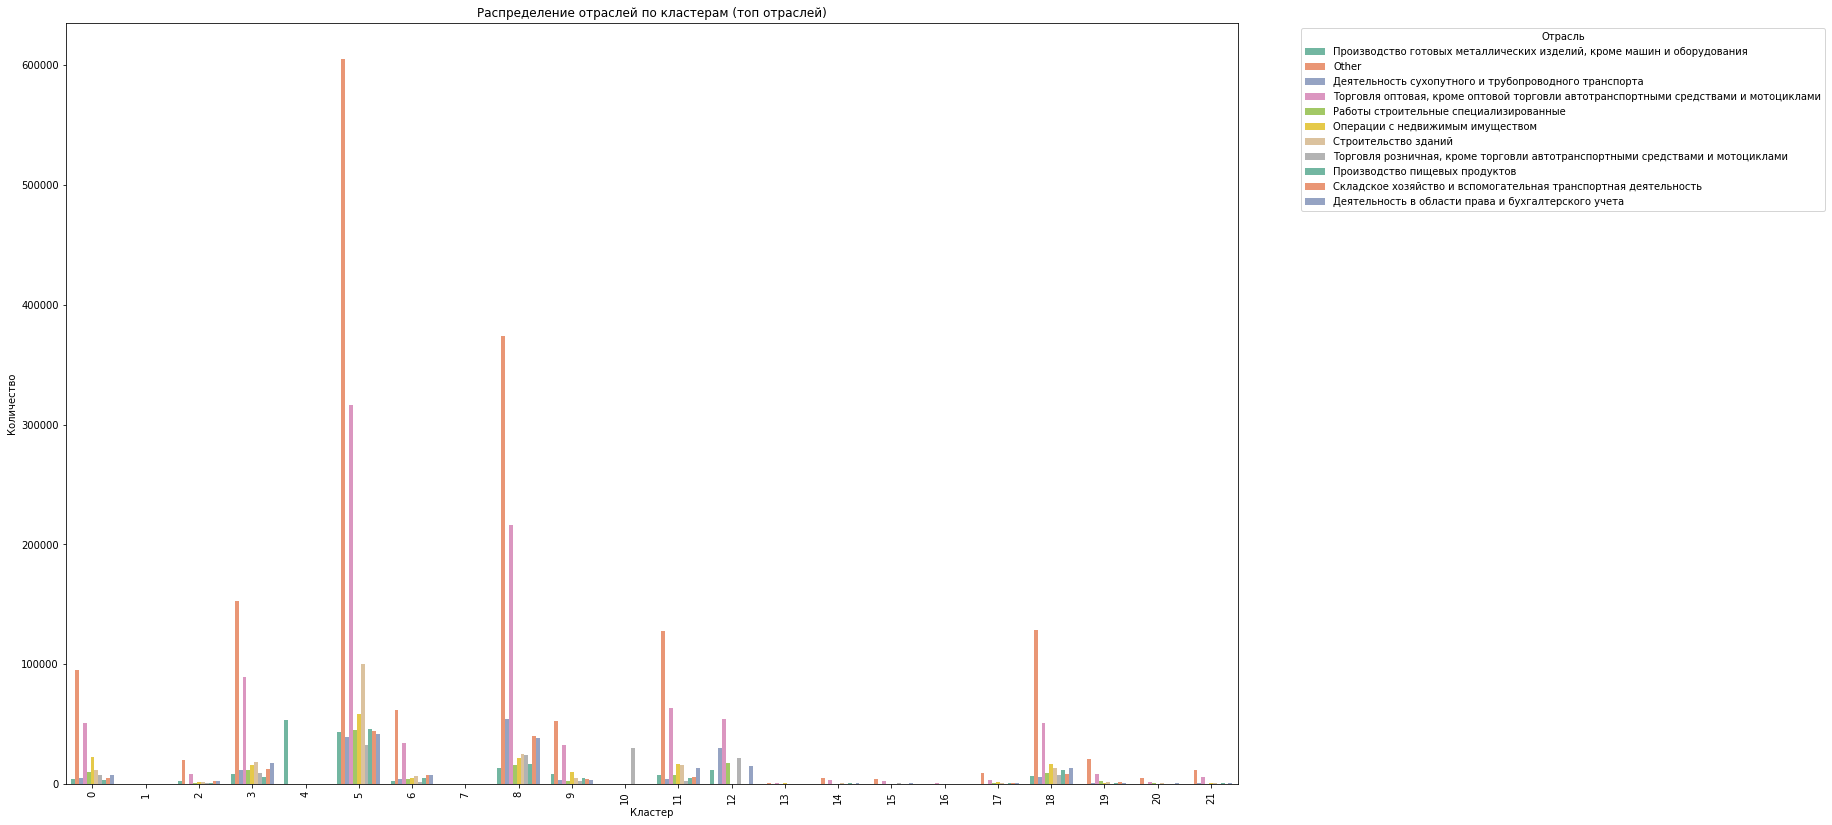

In [4]:
# определение количества топ-отраслей для отображения
top_n = 10  # Можете изменить количество топ-отраслей
industry_counts = filtered_df['industry_name'].value_counts()
top_industries = industry_counts.head(top_n).index

# замена менее распространенных отраслей на "Other"
filtered_df['industry_name_top'] = filtered_df['industry_name'].apply(lambda x: x if x in top_industries else 'Other')

# визуализация распределения отраслей по кластерам
plt.figure(figsize=(21, 14))
sns.countplot(data=filtered_df, x='cluster', hue='industry_name_top', palette='Set2')
plt.title('Распределение отраслей по кластерам (топ отраслей)')
plt.xlabel('Кластер')
plt.ylabel('Количество')
plt.legend(title='Отрасль', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.show()

**Интерпретация графика:**

	1.Кластеры с наибольшим количеством пользователей:
	Кластеры 0, 3, 5, 8, 11, 18 имеют наибольшее количество пользователей. Это видно по высоте столбцов, которые значительно выше по сравнению с другими кластерами.
	2.Преобладающие отрасли:
	Оранжевые столбцы, которые представляют собой другие отрасли в кластере, помимо выделяющегося топа, доминируют в нескольких кластерах, особенно в кластерах 3, 5, 8, 11 и 18. Это указывает на то, что пользователи из оставшихся отраслей составляют значительную часть этих кластеров.
	3.Отрасли с меньшим количеством пользователей:
	Некоторые отрасли, обозначенные другими цветами, имеют меньшее количество пользователей и представлены менее заметными столбцами на графике.

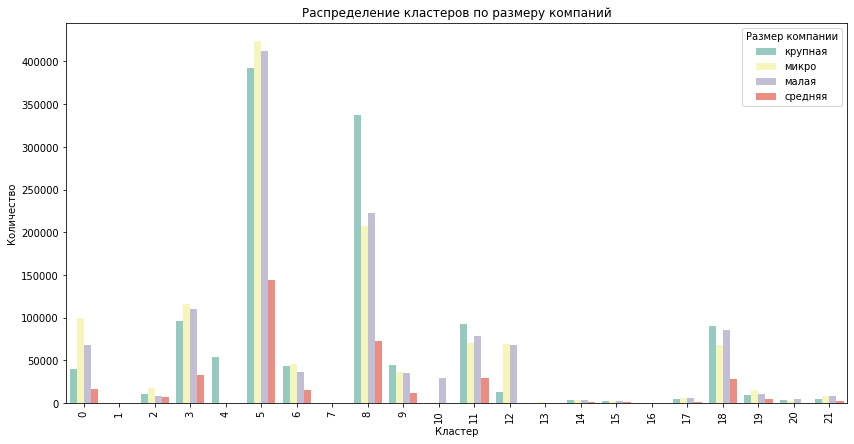

In [5]:
# Распределение размеров компаний по кластерам
plt.figure(figsize=(14, 7))
sns.countplot(data=filtered_df, x='cluster', hue='company_size', palette='Set3')
plt.title('Распределение кластеров по размеру компаний')
plt.xlabel('Кластер')
plt.ylabel('Количество')
plt.legend(title='Размер компании')
plt.xticks(rotation=90)  # Поворот меток кластеров для удобства чтения
plt.show()

**Интерпретация графика:**

	1. Кластеры с наибольшим количеством пользователей:
	Кластеры 5, и 8 имеют наибольшее количество пользователей, что видно по высоте столбцов. И значительно различаются по размерам компаний.
	2. Преобладающие размеры компаний в кластерах:
    Пример
	Кластер 5: Преобладают пользователи из микро компаний. Но также значительное количество пользователей из микро- и малых компаний.
	Кластер 8: Преобладают пользователи из крупных компаний.
	3. Различия между кластерами:
	Некоторые кластеры показывают значительное преобладание определенного размера компании, в то время как в других кластерах распределение более равномерное.

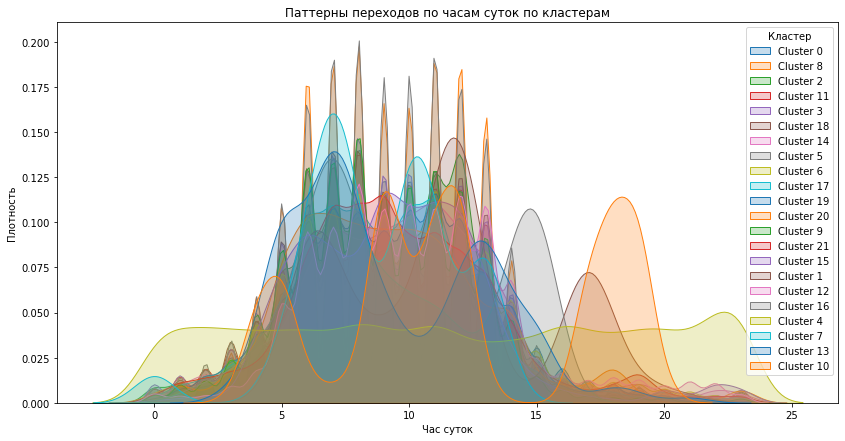

In [6]:
# Временные паттерны переходов по кластерам (по часам суток)
plt.figure(figsize=(14, 7))
for cluster in filtered_df['cluster'].unique():
    cluster_data = filtered_df[filtered_df['cluster'] == cluster]
    sns.kdeplot(cluster_data['datetime'].dt.hour, label=f'Cluster {cluster}', fill=True)

plt.title('Паттерны переходов по часам суток по кластерам')
plt.xlabel('Час суток')
plt.ylabel('Плотность')
plt.legend(title='Кластер')
plt.show()

Интерпретация графика:

	1. Пики активности:
	Утренние и дневные часы: Большинство кластеров демонстрируют высокую активность в утренние часы (около 8-11 часов) и дневные часы (около 13-15 часов). Это видно по множественным пикам плотности в этих временных интервалах.
	Вечерние часы: Некоторые кластеры демонстрируют повышенную активность в вечерние часы (около 18-20 часов), например, кластер 10, кластер 4.
	2. Кластеры с четкими пиками:
	Кластеры 0, 2, 5, 7 и 10 имеют ярко выраженные пики активности в утренние и дневные часы. Это указывает на то, что пользователи в этих кластерах имеют четкие временные паттерны переходов.
	Например, кластер 2 и кластер 10 имеют ярко выраженные пики активности в утренние и вечерние часы, соответственно.
	3. Кластеры с равномерным распределением:
	Некоторые кластеры имеют более равномерное распределение активности в течение суток, без явно выраженных пиков. Например, кластеры 4 и 12 демонстрируют более равномерную активность в течение дня.


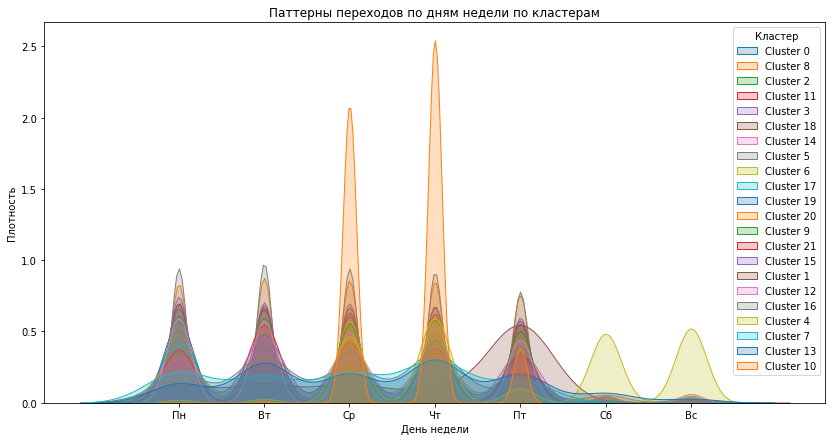

In [7]:
# Временные паттерны переходов по кластерам (по дням недели)
plt.figure(figsize=(14, 7))
for cluster in filtered_df['cluster'].unique():
    cluster_data = filtered_df[filtered_df['cluster'] == cluster]
    sns.kdeplot(cluster_data['datetime'].dt.dayofweek, label=f'Cluster {cluster}', fill=True)

plt.title('Паттерны переходов по дням недели по кластерам')
plt.xlabel('День недели')
plt.ylabel('Плотность')
plt.xticks(ticks=range(7), labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.legend(title='Кластер')
plt.show()

Интерпретация графика:

	1. Пики активности по дням недели:
	Среда и Четверг: Многие кластеры демонстрируют высокую активность в среду и четверг, что видно по множественным пикам плотности в эти дни. Это указывает на то, что пользователи в этих кластерах чаще совершают переходы в середине недели.
	Пятница и выходные: Активность пользователей снижается в пятницу, субботу и воскресенье. Это видно по уменьшению плотности в эти дни. Однако, есть кластер №4, который активен и в субботу и в воскресенье.
	2. Кластеры с четкими пиками:
	Многие кластеры имеют пики активности в среду и четверг. Это указывает на то, что пользователи в этих кластерах имеют ярко выраженные паттерны переходов в середине недели. В некоторых, лидирующими являются понедельник и вторник.
	3. Кластеры с равномерным распределением:
	Некоторые кластеры имеют более равномерное распределение активности в течение недели, без явно выраженных пиков. Например, кластеры 1, 3 и 6 демонстрируют более равномерную активность в течение недели.
	4. Различия между кластерами:
	График показывает, что разные кластеры имеют разные временные паттерны активности по дням недели. Например, кластер 2 и кластер 8 активны в среду и четверг, тогда как кластеры 1 и 3 имеют более равномерное распределение активности.

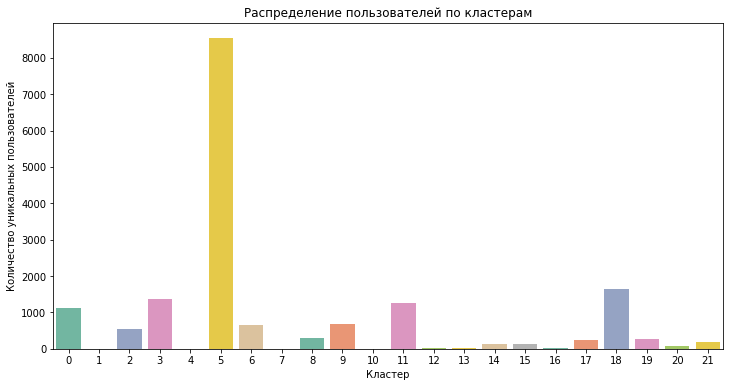

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Подсчет количества уникальных пользователей в каждом кластере
cluster_counts = filtered_df.groupby('cluster')['user_id'].nunique().reset_index()
cluster_counts.columns = ['cluster', 'user_count']

# Визуализация распределения пользователей по кластерам
plt.figure(figsize=(12, 6))
sns.barplot(x='cluster', y='user_count', data=cluster_counts, palette='Set2')
plt.title('Распределение пользователей по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Количество уникальных пользователей')
plt.show()

In [9]:
cluster_counts

,cluster,user_count
0,0,1112
1,1,7
2,2,532
3,3,1378
4,4,1
5,5,8538
6,6,656
7,7,8
8,8,298
9,9,686


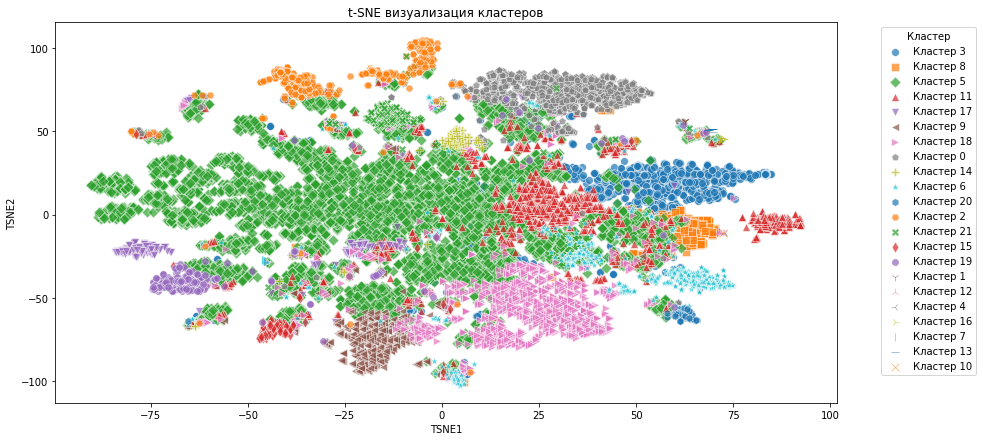

In [10]:
from sklearn.manifold import TSNE

# # Применение t-SNE для уменьшения размерности
# tsne = TSNE(n_components=2, random_state=42)
# X_tsne = tsne.fit_transform(X_scaled)

# # Создание DataFrame для визуализации
# tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
# tsne_df['cluster'] = user_behavior['cluster']

# # Визуализация t-SNE
# plt.figure(figsize=(14, 7))
# sns.scatterplot(x='TSNE1', y='TSNE2', hue='cluster', palette='Set2', data=tsne_df)
# plt.title('t-SNE визуализация кластеров')
# plt.xlabel('TSNE1')
# plt.ylabel('TSNE2')
# plt.legend(title='Кластер')
# plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

# Применение t-SNE для уменьшения размерности
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Создание DataFrame для визуализации
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['cluster'] = user_behavior['cluster']

# Определение палитры и маркеров
palette = sns.color_palette("tab20", 22)
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', 'P', '*', 'h', 'H', 'X', 'd', '8', '1', '2', '3', '4', '|', '_', 'x']

# Визуализация t-SNE
plt.figure(figsize=(14, 7))
for i, cluster in enumerate(tsne_df['cluster'].unique()):
    sns.scatterplot(x='TSNE1', y='TSNE2', data=tsne_df[tsne_df['cluster'] == cluster], 
                    label=f'Кластер {cluster}', palette=palette, s=60, alpha=0.7, edgecolor='w', marker=markers[i % len(markers)])

plt.title('t-SNE визуализация кластеров')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.legend(title='Кластер', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [24]:
import pandas as pd
import openpyxl
from openpyxl.utils import get_column_letter
from openpyxl.formatting.rule import ColorScaleRule
from openpyxl.worksheet.table import Table, TableStyleInfo

# Загрузка данных
data = filtered_df

# Определение топ 15 самых посещаемых событий
top_15_events = data['link'].value_counts().nlargest(15)

# Подсчет общего количества уникальных пользователей в месяц
total_unique_users = data['user_id'].nunique()

# Подсчет общего количества всех переходов
total_events = data.shape[0]

# Создание DataFrame для хранения результатов для первого листа
results = []

# Обработка данных для каждого из топ 15 событий
for event in top_15_events.index:
    event_data = data[data['link'] == event]
    
    # Подсчет общего количества событий по отраслям для текущего события
    industry_event_counts = event_data['industry_name'].value_counts().nlargest(15)
    
    # Подсчет общего количества событий для каждого события
    total_event_count = top_15_events[event]
    
    # Подсчет количества уникальных пользователей для данного события
    unique_users_count = event_data['user_id'].nunique()
    
    # Самая популярная отрасль для данного события
    top_industry = industry_event_counts.idxmax() if not industry_event_counts.empty else ""
    
    # Подсчет процента пользователей от общего количества уникальных пользователей, посетивших за месяц сервис
    percentage_users = (unique_users_count / total_unique_users) * 100
    
    # Заполнение строки для таблицы
    row = [event, list(industry_event_counts.index), top_industry, f'{percentage_users:.2f}%', unique_users_count]
    results.append(row)

# Создание DataFrame из результатов
columns = ['Событие', 'Популярные отрасли', 'Самая популярная отрасль', '% от всех пользователей', 'Уникальные пользователи']
results_df = pd.DataFrame(results, columns=columns)

# Определение топ 15 самых популярных отраслей
top_15_industries = data['industry_name'].value_counts().nlargest(15)

# Создание DataFrame для второго листа
industry_results = []

# Обработка данных для каждой из топ 15 отраслей
for industry in top_15_industries.index:
    industry_data = data[data['industry_name'] == industry]
    
    # Определение двух самых популярных событий, исключая "Рекомендации (главное)"
    top_event_series = industry_data['link'].value_counts()
    
    if "Рекомендации (главное)" in top_event_series.index:
        top_event_series = top_event_series.drop("Рекомендации (главное)")
    
    if len(top_event_series) > 0:
        top_event = top_event_series.idxmax()
        event_count = top_event_series.max()
        percentage_event = (event_count / total_events) * 100
    else:
        top_event = ""
        event_count = 0
        percentage_event = 0
    
    # Подсчет количества уникальных пользователей для данной отрасли
    unique_users_industry = industry_data['user_id'].nunique()
    
    # Заполнение строки для таблицы
    row = [industry, top_event, event_count, f'{percentage_event:.2f}%', unique_users_industry]
    industry_results.append(row)

# Создание DataFrame из результатов
industry_columns = ['Отрасль', 'Самое популярное событие', 'Количество переходов', '% от всех переходов', 'Уникальные пользователи']
industry_df = pd.DataFrame(industry_results, columns=industry_columns)

# Сохранение данных в Excel файл
with pd.ExcelWriter('top_events_industries.xlsx', engine='openpyxl') as writer:
    results_df.to_excel(writer, sheet_name='Top Events', index=False)
    industry_df.to_excel(writer, sheet_name='Industry Events', index=False)

# Загрузка созданного файла для дальнейшей работы с openpyxl
workbook = openpyxl.load_workbook('top_events_industries.xlsx')

# Форматирование первого листа
sheet1 = workbook['Top Events']

# Добавление стиля таблицы
tab1 = Table(displayName="TopEventsTable", ref=f"A1:{get_column_letter(sheet1.max_column)}{sheet1.max_row}")
style1 = TableStyleInfo(name="TableStyleMedium9", showFirstColumn=False,
                       showLastColumn=False, showRowStripes=True, showColumnStripes=True)
tab1.tableStyleInfo = style1
sheet1.add_table(tab1)

# Применение условного форматирования для процентов
color_scale_rule_percent = ColorScaleRule(start_type='num', start_value=0, start_color='FF0000',
                                  mid_type='num', mid_value=50, mid_color='FFFF00',
                                  end_type='num', end_value=100, end_color='00FF00')
sheet1.conditional_formatting.add(f'D2:D{sheet1.max_row}', color_scale_rule_percent)

# Применение условного форматирования для уникальных пользователей
color_scale_rule_users = ColorScaleRule(start_type='num', start_value=min(results_df['Уникальные пользователи']),
                                        start_color='FF0000', mid_type='num', mid_value=(min(results_df['Уникальные пользователи']) + max(results_df['Уникальные пользователи'])) / 2,
                                        mid_color='FFFF00', end_type='num', end_value=max(results_df['Уникальные пользователи']), end_color='00FF00')
sheet1.conditional_formatting.add(f'E2:E{sheet1.max_row}', color_scale_rule_users)

# Форматирование второго листа
sheet2 = workbook['Industry Events']

# Добавление стиля таблицы
tab2 = Table(displayName="IndustryEventsTable", ref=f"A1:{get_column_letter(sheet2.max_column)}{sheet2.max_row}")
style2 = TableStyleInfo(name="TableStyleMedium9", showFirstColumn=False,
                       showLastColumn=False, showRowStripes=True, showColumnStripes=True)
tab2.tableStyleInfo = style2
sheet2.add_table(tab2)

# Применение условного форматирования для количества переходов
sheet2.conditional_formatting.add(f'C2:C{sheet2.max_row}', color_scale_rule_percent)

# Применение условного форматирования для процентов переходов
sheet2.conditional_formatting.add(f'D2:D{sheet2.max_row}', color_scale_rule_percent)

# Применение условного форматирования для уникальных пользователей
sheet2.conditional_formatting.add(f'E2:E{sheet2.max_row}', color_scale_rule_users)

# Сохранение изменений
workbook.save('top_events_industries.xlsx')

print("Данные сохранены в файл top_events_industries.xlsx с условным форматированием.")

Данные сохранены в файл top_events_industries.xlsx с условным форматированием.


In [25]:
import pandas as pd
import openpyxl
from openpyxl.utils import get_column_letter
from openpyxl.formatting.rule import ColorScaleRule
from openpyxl.worksheet.table import Table, TableStyleInfo

# Загрузка данных
data = filtered_df

# Подсчет общего количества уникальных пользователей в месяц
total_unique_users = data['user_id'].nunique()

# Размеры компаний
company_sizes = ['крупная', 'микро', 'малая', 'средняя']

# Создание ExcelWriter объекта для сохранения результатов в Excel файл
with pd.ExcelWriter('company_size_events.xlsx', engine='openpyxl') as writer:

    # Обработка данных для каждого размера компании
    for size in company_sizes:
        size_data = data[data['company_size'] == size]
        
        # Определение топ 15 самых посещаемых событий для данного размера компании
        top_15_events = size_data['link'].value_counts().nlargest(15)
        
        # Создание DataFrame для хранения результатов
        results = []
        
        # Обработка данных для каждого из топ 15 событий
        for event in top_15_events.index:
            event_data = size_data[size_data['link'] == event]
            
            # Подсчет общего количества событий по отраслям для текущего события
            industry_event_counts = event_data['industry_name'].value_counts().nlargest(15)
            
            # Подсчет количества уникальных пользователей для данного события
            unique_users_count = event_data['user_id'].nunique()
            
            # Подсчет процента пользователей данного размера компании от общего количества уникальных пользователей
            percentage_users = (unique_users_count / total_unique_users) * 100
            
            # Заполнение строки для таблицы
            row = [size, event, list(industry_event_counts.index), f'{percentage_users:.2f}%']
            results.append(row)
        
        # Создание DataFrame из результатов
        columns = ['Размер компании', 'Событие', 'Популярные отрасли', '% от всех пользователей']
        results_df = pd.DataFrame(results, columns=columns)
        
        # Запись данных на соответствующий лист
        sheet_name = size.capitalize()
        results_df.to_excel(writer, sheet_name=sheet_name, index=False)
        
        # Форматирование листа
        workbook = writer.book
        sheet = workbook[sheet_name]
        
        # Добавление стиля таблицы
        tab = Table(displayName=f"{sheet_name}Table", ref=f"A1:{get_column_letter(sheet.max_column)}{sheet.max_row}")
        style = TableStyleInfo(name="TableStyleMedium9", showFirstColumn=False,
                               showLastColumn=False, showRowStripes=True, showColumnStripes=True)
        tab.tableStyleInfo = style
        sheet.add_table(tab)
        
        # Применение условного форматирования для процентов
        color_scale_rule_percent = ColorScaleRule(start_type='num', start_value=0, start_color='FF0000',
                                                  mid_type='num', mid_value=50, mid_color='FFFF00',
                                                  end_type='num', end_value=100, end_color='00FF00')
        sheet.conditional_formatting.add(f'D2:D{sheet.max_row}', color_scale_rule_percent)

# Сохранение изменений
print("Данные сохранены в файл company_size_events.xlsx с условным форматированием.")

Данные сохранены в файл company_size_events.xlsx с условным форматированием.
